# <center> Introduction to Reinforcement Learning</center>

#### Import dependencies

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pickle

import sys
import os

from Practical07_Support.gym_simple_gridworlds.helper import *
from Practical07_Support.gym_simple_gridworlds.envs.grid_env import GridEnv
from Practical07_Support.gym_simple_gridworlds.envs.grid_2dplot import *


from IPython.display import display, HTML

# Activity 1. Elements of an MDP (Grid World Example)

Recall the grid in which our robot lives

![GridWorldExample.png](https://i.postimg.cc/5tMM5vqf/Grid-World-Example.png)

- The states $s \in \mathcal{S}$ correspond to locations in the grid. Each location has also a cell index associated to it, e.g., cell index 4 is associated to location (row=1,col=0)
- The robot can move up, down, left, or right. Actions correpond to unit increments or decrements in the specified direction.
    - Up : (-1,0)
    - Down: (1,0)
    - Left: (0,-1)
    - Right: (0, 1)
- Each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3. No actions are available at a terminal state

## Create Environment and Explore its Attributes

The noise parameter corresponds to the probability of a change of direction when an action is taken (e.g., going left/right when agent decides to move up/down)

In [15]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)

### State and Action Spaces

Let's take a look at the state and action spaces of our environment

In [16]:
# State (or observation) space
print(grid_world.observation_space)
print(grid_world.get_states())
print()

# Action space
print(grid_world.action_space)
print(grid_world.get_actions())

Discrete(11)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Discrete(4)
[0, 1, 2, 3]


### Transition Function

Let's take a look at the current state transition function. Some things to keep in mind regarding the transition function:

1. Given that $\mathcal{T}: \mathcal{S} \times \mathcal{A} \times \mathcal{S} \rightarrow \mathbb{R}$, the ``state_transitions`` attribute of the class ``GridEnv`` corresponds to a 3-Dimensional numpy array of size $11\times4\times11$.
2. With a noise attribute set to 0.2, at state 5, if the agent chooses to move up, it will end up at:
    - state 2 with $80\%$ probability,
    - state 6 with $10\%$ probability, or
    - state 5 with $10\%$ probability

In [17]:
# at state 5 the agent takes action 0 (going up)
print(grid_world.state_transitions[5,0])

[0.  0.  0.8 0.  0.  0.1 0.1 0.  0.  0.  0. ]


### Living Reward and Reward Function

Let's now take a quick look at the living reward (i.e., running cost) and reward function $\mathcal{R}: \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$.

1. Living reward corresponds to the attribute ``living_rewards`` of the class ``GridEnv`` and is represented as an 1-Dimensional numpy array
2. The reward function corresponds to the attribute ``rewards`` of the class ``GridEnv`` and is also represented as a 2-Dimensional numpy array of size $11\times4$

In [18]:
# Living rewards
print("Living rewards for all states:\n{}\n".format(grid_world.immediate_rewards))

# Reward function, i.e., expected reward for taking action a at state s
s = 2
dir = 3
dir_str = ['up','down','left','right']
print("Reward function for all state-action pairs:\n{}\n".format(grid_world.rewards))
print("The expected reward at state {} if agent chooses to move {} is: {}".format(s, dir_str, grid_world.rewards[s,dir]))

# To do (Flux Quiz 2): what is the expected reward at state 2 if the agent chooses to move right?

Living rewards for all states:
[-0.04 -0.04 -0.04  1.   -0.04 -0.04 -1.   -0.04 -0.04 -0.04 -0.04]

Reward function for all state-action pairs:
[[-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [ 0.064  0.064 -0.04   0.792]
 [ 0.     0.     0.     0.   ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.136 -0.136 -0.04  -0.808]
 [ 0.     0.     0.     0.   ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.04  -0.04  -0.04  -0.04 ]
 [-0.808 -0.04  -0.136 -0.136]]

The expected reward at state 2 if agent chooses to move ['up', 'down', 'left', 'right'] is: 0.792


### Policy

Let's see the path and total reward of an agent moving on our grid world according to the following policy $\pi$

![example_policy.png](https://i.postimg.cc/pLjHnkj0/example-policy.png)

In [19]:
# We represent this policy as a 2-Dimensional numpy array
policy_matrix = np.array([[3,      3,  3,  -1],
                          [0, np.NaN,  0,  -1],
                          [0,      2,  0,   2]])

In [20]:
print(grid_world.grid)

[[ 0.  1.  2.  3.]
 [ 4. nan  5.  6.]
 [ 7.  8.  9. 10.]]


Let's now apply this policy and observe the agent's behavior (blue dot in the figure shown below).

In [21]:
# Create a Grid World instance
grid_world = GridEnv(gamma=0.9, noise=0.5, living_reward=-0.04)
s_x, s_y = get_state_to_plot(grid_world)

# We can visualize our grid world using the render() function
fig, ax = grid_world.render()
agent, = ax.plot([], [], 'o', color='b', linewidth=6)
reward_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

done = False
cumulative_reward = 0
cur_state = grid_world.cur_state
path_to_plot = []

while not done:
    _, cur_reward, done, _ = grid_world.step(int(policy_matrix[cur_state[0], cur_state[1]]))
    cur_state = grid_world.cur_state
    n_x, n_y = get_state_to_plot(grid_world)
    cumulative_reward += cur_reward
    path_to_plot.append([cumulative_reward, n_x, n_y])

def init():
    agent.set_data([s_x + 0.5], [s_y + 0.5])
    reward_text.set_text('')
    return agent, reward_text

def animate(i):
    if i < len(path_to_plot):
        r, n_x, n_y = path_to_plot[i]
        agent.set_data([n_x + 0.5], [n_y + 0.5])
        reward_text.set_text('Cumulative reward: %.2f' % r)
    return agent, reward_text

ani = animation.FuncAnimation(fig, animate, frames=len(path_to_plot), blit=False, interval=500, init_func=init,
                              repeat=False)

plt.close('all') 
display(HTML(f"<div align=\"center\">{ani.to_jshtml()}</div>"))

# Activity 2. Iterative Policy Evaluation

Recall the definition of the iterative policy evaluation algorithm

![IterativePolicyEvaluation.png](https://i.postimg.cc/MGbJ9TdV/Iterative-Policy-Evaluation.png)

Let's now compute the value function of the same policy $\pi$ 

![example_policy.png](https://i.postimg.cc/pLjHnkj0/example-policy.png)

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- A non-zero living cost and big rewards are obtained at terminal states (class attribute ``living_reward=-0.04``)

We have defined the helper function ``encode_policy()`` to encode the policy $\pi$ shown in the image above. The return variable ``policy_pi`` is a dictionary of dictionaries, where each element corresponds to the probability of selecting an action $a$ at a given state $s$

Keep in mind that each action is represented by a number. Action (Up) is represented by 0, (Down) by 1, (Left) by 2 and, finally, (Right) by 3.

In [22]:
grid_world = GridEnv(gamma=0.9, noise=0.2, living_reward=-0.04)
policy_pi = encode_policy(grid_world)

print("Action probabilities at state 0 are:\n{}".format(policy_pi[0]))

Action probabilities at state 0 are:
defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0})


Given the policy $\pi$, let's know compute its state-value function using iterative policy evaluation.

**TODO** (Flux Quiz 3): 
Complete the computation of value function update for each state. We have decomposed this computation into 2 steps:

1. Compute discounted sum of state values of all successor states: $v_{\text{discounted}} = \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v(s')$ for each action


2. Compute expectation over all actions: $\sum_{a \in \mathcal{A}}\pi(a|s)(\mathcal{R}(s,a) + v_{\text{discounted}})$ 


**Keep in Mind**: Correspondance between the mathematical notation and implemented code

|                         |                                                    |                 |
| ----------------------- | -------------------------------------------------- | --------------- |
|                         | **Variable/Attribute**                             | **Type**        | 
| $\gamma$                | `grid_world.gamma`                                 | `float`         |
| $\mathcal{T}(s, a, s')$ | `grid_world.state_transitions[idx_s, idx_a, idx_s]`| `numpy` 3d-array| 
| $\mathcal{R}(s, a)$     | `grid_world.rewards[idx_s, idx_a]`                 | `numpy` 2d-array| 
| $\pi(a\vert s)$         | `policy_pi[idx_s][idx_a]`                          | `dict` of `dict`| 
| $v_\pi(s)$              | `v[idx_s]`                                         | `dict`          | 


{0: 0.6104616651397075, 1: 0.7662070655051755, 2: 0.9281802698515482, 3: 0, 4: 0.48723450952435526, 5: 0.5849338398682042, 6: 0, 7: 0.3687449747446223, 8: 0.2749948818865121, 9: 0.4225398675077873, 10: 0.184866668038501}


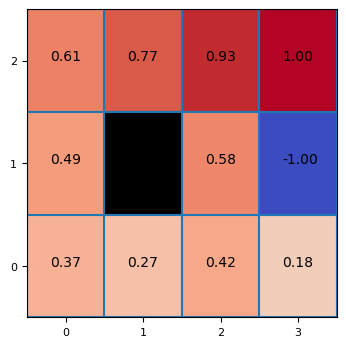

In [23]:
def policy_evaluation(grid_env, policy, plot=False, threshold=0.00001):
    
    """
    This function computes the value function for a policy pi in a given environment grid_env.
    
    :param grid_env (GridEnv): MDP environment
    :param policy (dict - stochastic form): Policy being evaluated
    :return: (dict) State-values for all non-terminal states
    """
        
    # Obtain list of all states in environment
    v = {s: 0.0 for s in grid_env.get_states()}
    theta = threshold
    delta = 1000

    while delta > theta:
        delta = 0.0
        # For all states
        for s in v.keys():

            old_v = v[s]
            new_v = 0

            # For all actions
            for a, probability_a in policy[s].items():
                discounted_v = 0

                # For all states that are reachable from s with action a
                for s_next in grid_env.get_states():
                    #TODO 1: Compute discounted sum of state values for all successor states ---------
                    discounted_v += grid_env.state_transitions[s,a,s_next]*v[s_next]
                    #ENDTODO -------------------------------------------------------------------------
                discounted_v *= grid_env.gamma
                #TODO 2: Compute expectation over all actions ------------------------------------
                new_v += policy[s][a]*(grid_env.rewards[s,a] + discounted_v)
                #ENDTODO -------------------------------------------------------------------------

            v[s] = new_v
            delta = max(delta, np.abs(old_v - new_v))

    if plot:
        plot_value_function(grid_env, v)
        
    return v
        
        
# Call the policy evalution function
v = policy_evaluation(grid_world, policy_pi, plot=True)
print(v)

# Activity 3. Policy Iteration

Recall the definition of the policy iteration algorithm

![PolicyIteration.png](https://i.postimg.cc/26kRMDKJ/Policy-Iteration.png)

Starting with a random policy, let's find the optimal policy for a grid world environment with attributes:

We consider a grid world environment with the following attributes:
- Discount factor $\gamma = 0.9$ (class attribute ``gamma=0.9``)
- Stochastic transition matrix (class attribute ``noise=0.2``)
- Rewards are only obtained at terminal states (class attribute ``living_reward=-0.04``)

We make use of some helper methods:
- ``one_step_look_ahead(grid_env, state, value_function)`` in ``Support/gym_simple_gridworlds/helper.py``, this method computes the action-value function for a state $s$ given the state-value function $v$. This corresponds to $\mathcal{R}(s,a) + \gamma\sum_{s' \in \mathcal{S}}\mathcal{T}(s,a,s')v_\pi(s')\, \forall \, a \in \mathcal{A}$


- ``update_policy(grid_world, policy, value_function)`` in ``Support/gym_simple_gridworlds/helper.py``, this method updates the current policy $\pi$ given the state-value function $v$ by taking the action $a$ with the highest action-value. 


- ``define_random_policy(grid_env)`` in ``Support/gym_simple_gridworlds/helper.py``, this method generates a random policy for environment ``grid_env``

Let's now define the policy iteration core algorithm.

**TODO** (Flux Quiz 4): Complete the main steps of the policy iteration algoritm.
- Use ``policy_evaluation(.)`` in ``Support/gym_simple_gridworlds/helper.py`` to compute the state-value function of a given policy
- Use ``update_policy(.)`` in ``Support/gym_simple_gridworlds/helper.py`` to obtain an updated policy

In [24]:
def policy_iteration(grid_env, policy, plot=False):
    """
    This function iteratively updates a given policy pi for a given environment grid_env until convergence to optimal policy
    
    :param grid_env (GridEnv): MDP environment
    :param policy (matrix from): Deteministic policy being updated
    :return: (dict) State-values for all non-terminal states
    """
    prev_policy = np.zeros(policy.shape)
    
    while not np.all(np.equal(prev_policy, policy)):
        
        # Encode policy. This policy representation is needed for policy evaluation
        encoded_policy = encode_policy(grid_env, policy)
        # Set prev_policy to current policy
        prev_policy = policy.copy()
        
        #TODO 3: Complete the remaining steps---------------------------------------------
        # 1. Evaluate the given policy (policy_evaluation expects an
        #    mdp and the enconded_policy as arguments)
        ep_eval = policy_evaluation(grid_env, encoded_policy)
        # prev_eval = policy_evaluation(grid_env, prev_policy)

        # 2. Update policy using helper function update_policy
        # curr_policy = encoded_policy if ep_eval > prev_eval else prev_policy
        policy = update_policy(grid_env, encoded_policy, ep_eval)
        #ENDTODO -------------------------------------------------------------------------
        
    if plot:
        plot_policy(grid_env, policy)
    
    return policy


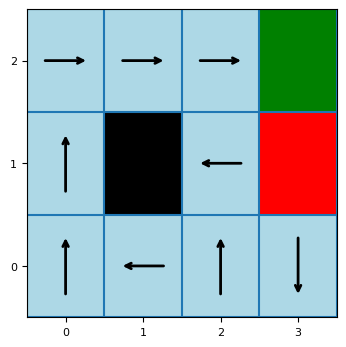

In [25]:
# Create a grid world mdp
grid_world = GridEnv(gamma=0.9, noise=0.5, living_reward=-0.04)

# Generate an initial random policy
initial_policy = define_random_policy(grid_world)

# Compute optimal policy using policy iteration
optimal_policy = policy_iteration(grid_world, initial_policy, plot=True)

In [26]:
print(optimal_policy)

defaultdict(<function encode_policy.<locals>.<lambda> at 0x000002DA69631700>, {0: defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}), 1: defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}), 2: defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}), 4: defaultdict(<class 'float'>, {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}), 5: defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}), 7: defaultdict(<class 'float'>, {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}), 8: defaultdict(<class 'float'>, {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}), 9: defaultdict(<class 'float'>, {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}), 10: defaultdict(<class 'float'>, {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}), 3: defaultdict(<class 'float'>, {}), 6: defaultdict(<class 'float'>, {}), (0, 0): 3, (0, 1): 3, (0, 2): 3, (1, 0): 0, (1, 2): 2, (2, 0): 0, (2, 1): 2, (2, 2): 0, (2, 3): 1})
